In [1]:
import joblib
import mylib
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from optuna.samplers import TPESampler

# from plotly import graph_objects as go
# from plotly import io as pio
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# import graphviz

# from sklearn.preprocessing import MinMaxScaler

In [38]:
REEXECUTE_OPTUNA_STUDY_KNN = False
REEXECUTE_OPTUNA_STUDY_RANDOM_FOREST = False

# Загрузка данных

Загрузим датасет, полученный ранее при создании простой модели, а также все исходный датасет для получения дополнительных характеристик для последующего анализа.

In [3]:
data_basic_model = pd.read_csv("full_data.csv")
data_basic_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24580 entries, 0 to 24579
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season_number            24580 non-null  int64  
 1   h_a                      24580 non-null  object 
 2   team                     24580 non-null  object 
 3   team_opp                 24580 non-null  object 
 4   scored                   24580 non-null  int64  
 5   missed                   24580 non-null  int64  
 6   result                   24580 non-null  object 
 7   pts                      24580 non-null  int64  
 8   league                   24580 non-null  object 
 9   date                     24580 non-null  object 
 10  points_after             24580 non-null  int64  
 11  points_before            24580 non-null  int64  
 12  round                    24580 non-null  int64  
 13  points_last_match        23896 non-null  float64
 14  points_last_matches   

Добавим в качестве признака номер сезона и разметим команду противника для каждого матча (каждой записи).

In [4]:
data = pd.read_csv("datasets\\understat_per_game.csv")
data["season_number"] = data["date"].astype("str").apply(mylib.get_season_number)
data_merged = data.merge(
    data[["team", "xG", "xGA", "date", "scored", "missed", "ppda_coef"]],
    left_on=["date", "xG", "xGA", "scored", "missed", "oppda_coef"],
    right_on=["date", "xGA", "xG", "missed", "scored", "ppda_coef"],
    suffixes=("", "_opp"),
    validate="one_to_one",
)
data_merged_filtered = data_merged[
    [
        "season_number",
        "h_a",
        "team",
        "team_opp",
        "scored",
        "missed",
        "result",
        "pts",
        "league",
        "date",
        "npxG",
        "npxGA",
        "deep",
        "deep_allowed",
        "ppda_coef",
        "oppda_coef",
    ]
].copy()
data_merged_filtered["match_label"] = data_merged_filtered.apply(
    lambda x: mylib.create_match_label(
        x["h_a"], x["team"], x["team_opp"], x["scored"], x["missed"]
    ),
    axis=1,
)

# Постановка задачи

Задача: предсказывать результат матчей (классификация: победа, ничья, поражение) в чемпионате на основании информации о последних пяти матчах команд и количества набранных очков в сезоне на момент начала встречи.

Формулировка задачи не изменилась, однако будут добавлены новые признаки, описанные далее.
Для оценки точности также будем использовать точность (Accuracy) и многоклассовую f1-меру. Добавим кросс-валидацию.

# Формирование дополнительных признаков

Аналогично полученным ранее данным (очки и голы в последних пяти матчах) получим средние статистические показатели за последние пять матчей.
Выбранные статистические показатели:
1. npxG - [non-penalty expected goals](https://dataglossary.wyscout.com/xg/) - статистический показатель, равный количеству ожидаемых голов (xG) без учета пенальти. Характеризует качество атаки команды. npxG может лучше характеризовать качество атаки команды, чем xG.
2. deep - [deep completion/entries](https://dataglossary.wyscout.com/deep_competion/) - количество проникновений в опасный радиус противника (20 метров от ворот) без учета навесов. Характеризует качество атаки команды.
3. npxGA и deep_allowed - аналогичные предыдущим двум параметры, но для команды соперника. Характеризуют качество обороны команды. Меньше показатели = меньше позволено противнику = лучше оборона.
4. ppda_coef - [passes per defensive action](https://www.coachesvoice.com/cv/ppda-explained-passes-per-defensive-action/) - количество пасов команды противника на оборонительное действие (отбор, перехват). Характеризует интенсивность прессинга команды. Меньше значение = больше интенсивность. Характеризует стиль игры команды.
5. oppda_coef - opponent's PPDA - интеснивность прессинга противника.

In [5]:
LAST_MATCHES_AMOUNT = 5

labels_for_rolling = [
    "npxG",
    "npxGA",
    "deep",
    "deep_allowed",
    "ppda_coef",
    "oppda_coef",
]

labels_aggregated = [label + "_avg" for label in labels_for_rolling]

grouped = data_merged_filtered.groupby(by=["season_number", "team"], sort=["date"])
data_grouped = data_merged_filtered.copy()

data_grouped[labels_aggregated] = (
    grouped[labels_for_rolling]
    .rolling(LAST_MATCHES_AMOUNT, closed="left")
    .mean()
    .reset_index(level=[0, 1])[labels_for_rolling]
)


data_basic_model[labels_aggregated] = data_grouped[labels_aggregated]

data_full = data_basic_model.merge(
    data_grouped[labels_aggregated + ["match_label", "date", "team"]].rename(
        columns={"team": "team_opp"}
    ),
    on=["match_label", "date", "team_opp"],
    suffixes=("", "_opp"),
    validate="one_to_one",
)
data_full["points_before"] /= data_full["round"] - 1
data_full["points_before_opp"] /= data_full["round_opp"] - 1
data_full[
    ["season_number", "round", "match_label", "points_before", "points_before_opp"]
    + labels_aggregated
    + [label + "_opp" for label in labels_aggregated]
].head(10)

,season_number,round,match_label,points_before,points_before_opp,npxG_avg,npxGA_avg,deep_avg,deep_allowed_avg,ppda_coef_avg,oppda_coef_avg,npxG_avg_opp,npxGA_avg_opp,deep_avg_opp,deep_allowed_avg_opp,ppda_coef_avg_opp,oppda_coef_avg_opp
0,1,1,Bayern Munich 2:1 Wolfsburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,Schalke 04 1:1 Bayern Munich,3.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,Bayern Munich 2:0 VfB Stuttgart,2.000000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,Hamburger SV 0:0 Bayern Munich,2.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,Bayern Munich 4:0 Paderborn,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,6,FC Cologne 0:2 Bayern Munich,2.200000,1.200000,1.964264,0.684500,11.4,2.4,5.622956,22.150800,0.690802,0.628713,4.0,5.2,15.957212,10.792701
6,1,7,Bayern Munich 4:0 Hannover 96,2.333333,1.666667,2.144172,0.609175,15.8,1.6,4.785956,26.598982,0.920050,1.111760,6.2,6.0,11.727434,9.890295
7,1,8,Bayern Munich 6:0 Werder Bremen,2.428571,0.571429,2.383274,0.436221,16.6,2.4,6.034737,33.534851,1.105101,1.405510,6.0,8.4,7.748333,5.862973
8,1,9,Borussia M.Gladbach 0:0 Bayern Munich,2.500000,2.000000,2.485398,0.374188,17.2,1.8,5.749282,35.902544,1.575171,0.717934,6.2,4.4,8.569664,14.785652
9,1,10,Bayern Munich 2:1 Borussia Dortmund,2.333333,0.777778,2.519300,0.463241,17.0,2.8,6.124667,39.384610,1.288864,1.117526,9.8,2.8,6.622593,11.971196


# Подготовка признаков

In [6]:
labels_basic_model = [
    "points_before",
    "points_last_matches",
    "scored_last_matches",
    "missed_last_matches",
    "points_before_opp",
    "points_last_matches_opp",
    "scored_last_matches_opp",
    "missed_last_matches_opp",
    "ishome",
    "result",
]
data_full_reduced = (
    data_full[
        labels_basic_model
        + labels_aggregated
        + [label + "_opp" for label in labels_aggregated]
    ]
    .dropna()
    .copy()
)
data_full_reduced.describe()

,points_before,points_last_matches,scored_last_matches,missed_last_matches,points_before_opp,points_last_matches_opp,scored_last_matches_opp,missed_last_matches_opp,npxG_avg,npxGA_avg,deep_avg,deep_allowed_avg,ppda_coef_avg,oppda_coef_avg,npxG_avg_opp,npxGA_avg_opp,deep_avg_opp,deep_allowed_avg_opp,ppda_coef_avg_opp,oppda_coef_avg_opp
count,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000,21152.000000
mean,1.372471,1.372646,1.332820,1.332139,1.372471,1.372646,1.332820,1.332139,1.190897,1.190480,5.772891,5.769280,10.802523,10.804454,1.190897,1.190480,5.772891,5.769280,10.802523,10.804454
std,0.510775,0.678767,0.667785,0.599115,0.510775,0.678767,0.667785,0.599115,0.455874,0.406742,2.678305,2.117075,3.476131,3.960056,0.455874,0.406742,2.678305,2.117075,3.476131,3.960056
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076943,0.201621,0.200000,0.600000,3.601372,3.119842,0.076943,0.201621,0.200000,0.600000,3.601372,3.119842
25%,1.000000,0.800000,0.800000,1.000000,1.000000,0.800000,0.800000,1.000000,0.873550,0.897201,4.000000,4.200000,8.378751,8.218854,0.873550,0.897201,4.000000,4.200000,8.378751,8.218854
50%,1.307692,1.400000,1.200000,1.200000,1.307692,1.400000,1.200000,1.200000,1.113076,1.148020,5.200000,5.600000,10.204992,10.038230,1.113076,1.148020,5.200000,5.600000,10.204992,10.038230
75%,1.684211,1.800000,1.600000,1.800000,1.684211,1.800000,1.600000,1.800000,1.425356,1.444098,7.000000,7.000000,12.564680,12.439825,1.425356,1.444098,7.000000,7.000000,12.564680,12.439825
max,3.000000,3.000000,5.000000,4.200000,3.000000,3.000000,5.000000,4.200000,3.834798,3.341566,23.200000,18.800000,41.046532,55.693690,3.834798,3.341566,23.200000,18.800000,41.046532,55.693690


## Корреляционная матрица

Ниже графически представлена матрица корреляции признаков: выбраны только признаки, соответствующие первой команде.

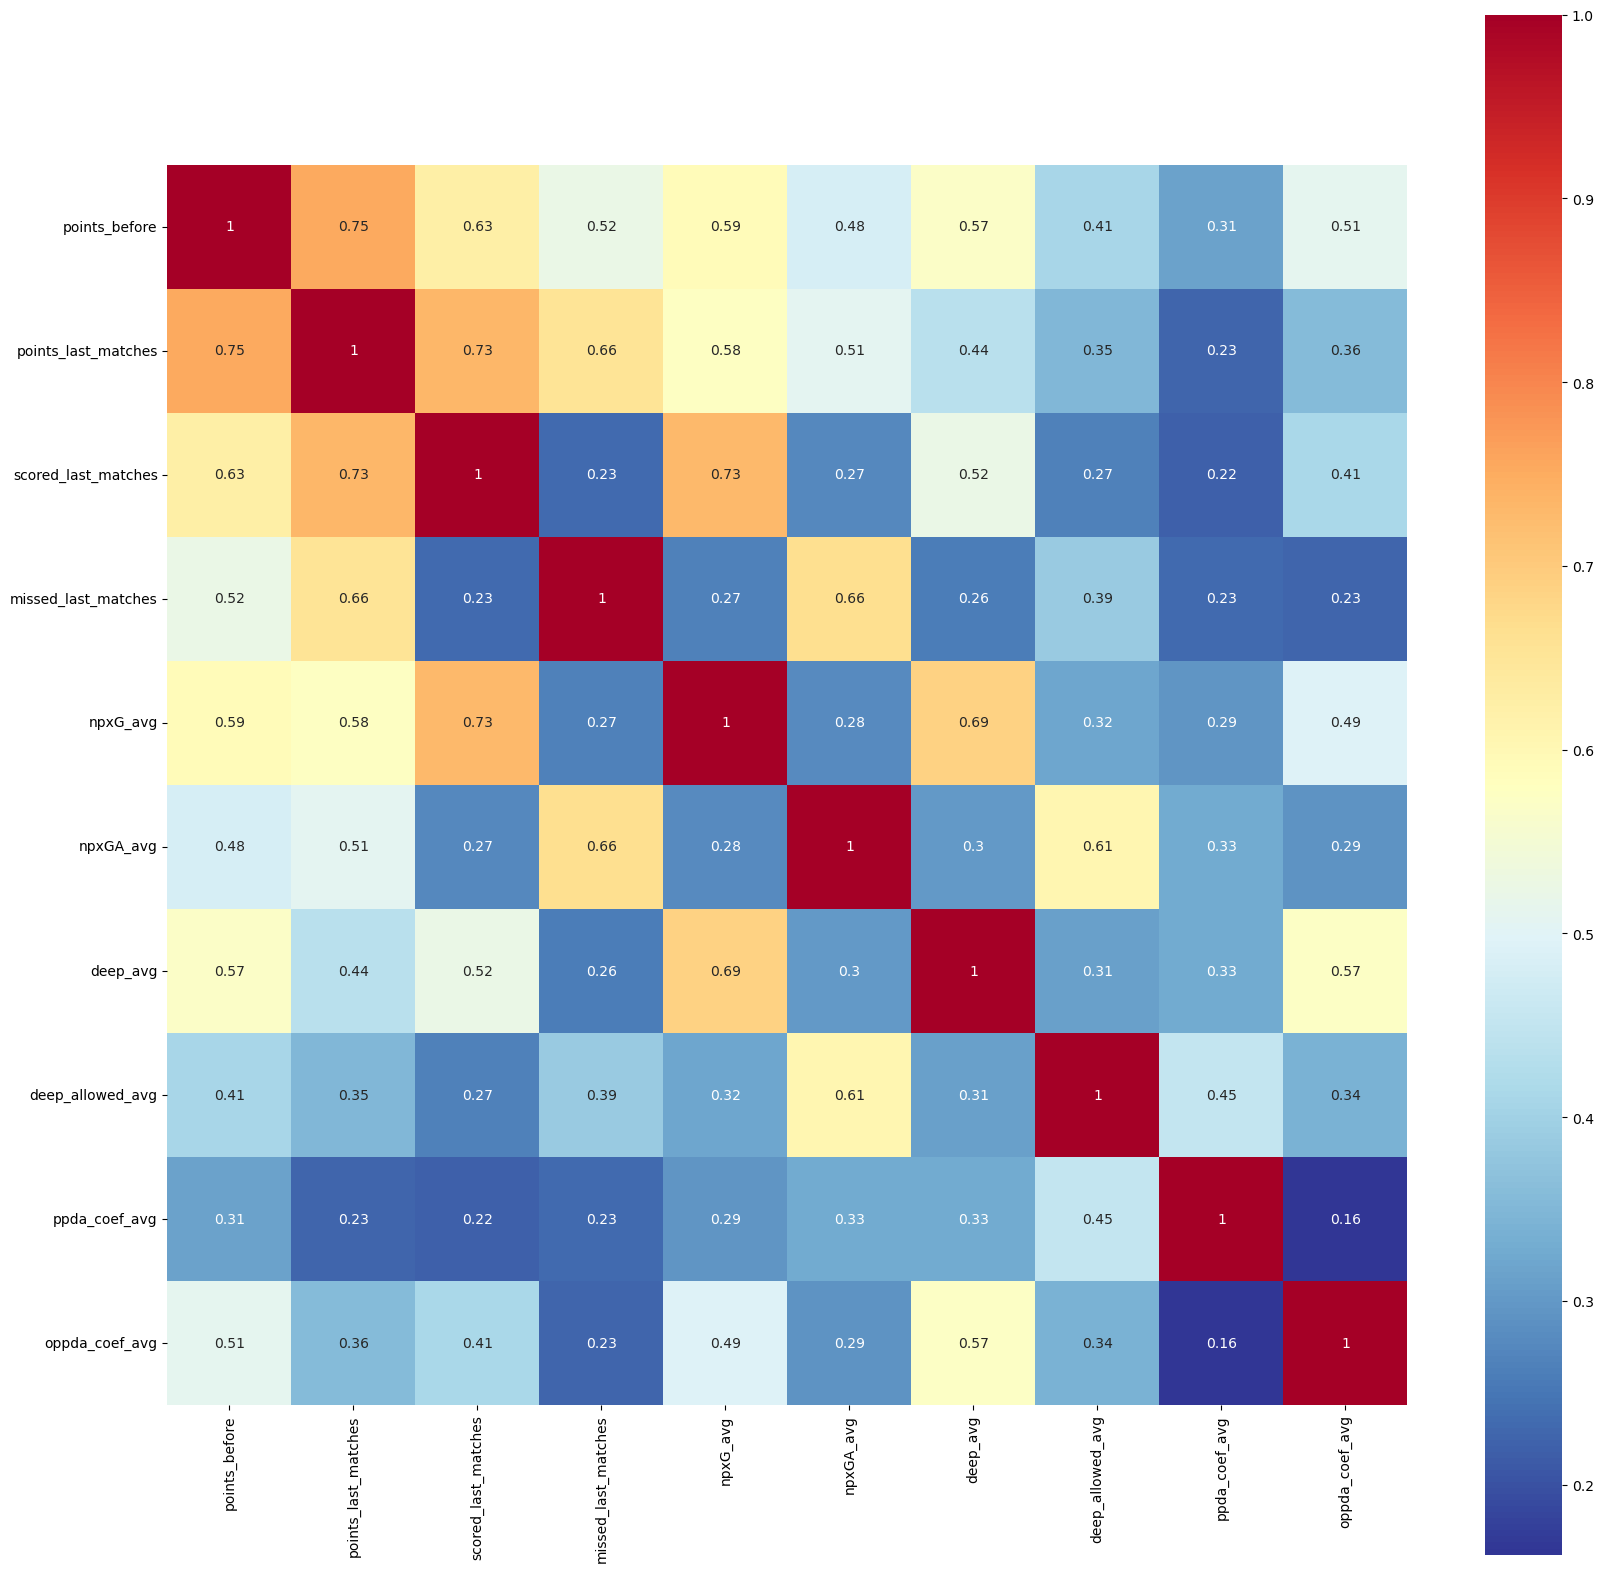

In [7]:
corrs = (
    data_full_reduced.filter(regex="^((?!_opp).)*$", axis=1)
    .select_dtypes(include="number")
    .corr()
)
plt.figure(figsize=(20, 20))
sns.heatmap(corrs.abs(), cmap="RdYlBu_r", square=True, annot=True);

## Гистограммы распределения признаков

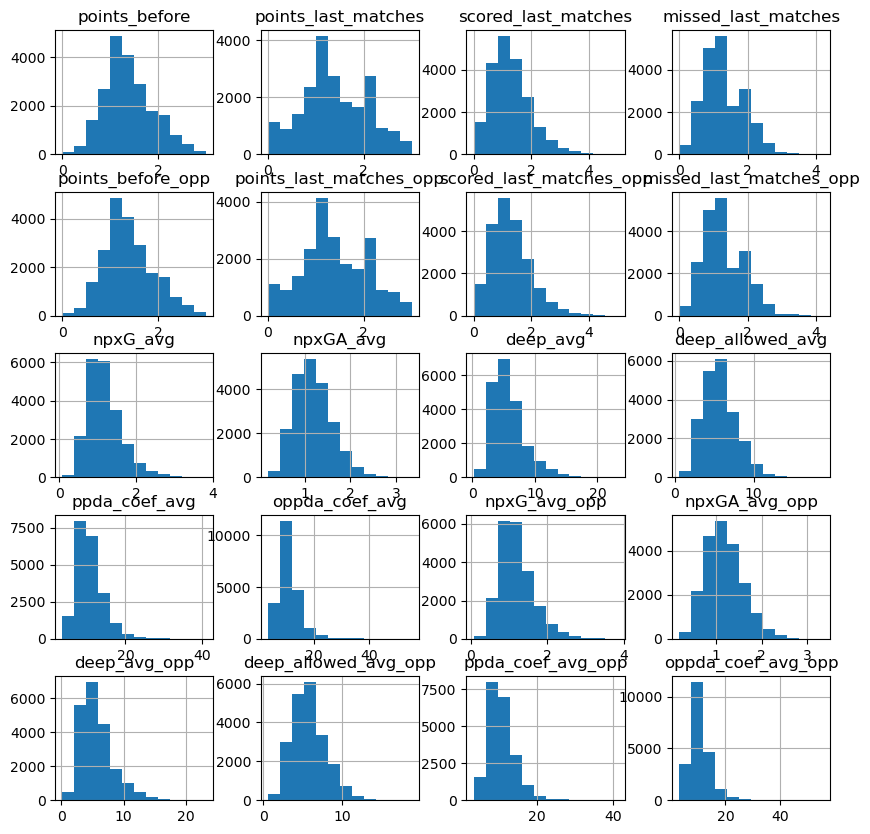

In [8]:
data_full_reduced.hist(bins=12, figsize=(10, 10));

На основании представленных диаграмм можно сделать вывод о том, что большинство признако имеют непопулярные высокие значения, которые можно удалить до обучения модели.

## Разделение на тренировочную и тестовую выборки

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data_full_reduced.drop(["result"], axis=1),
    data_full_reduced["result"],
    random_state=3456,
    test_size=0.25,
    stratify=data_full_reduced["result"],
)

## Фильтрация выбросов

Отфильтруем все признаки по границе 99-ого прецентиля для удаления экстремально больших значений.

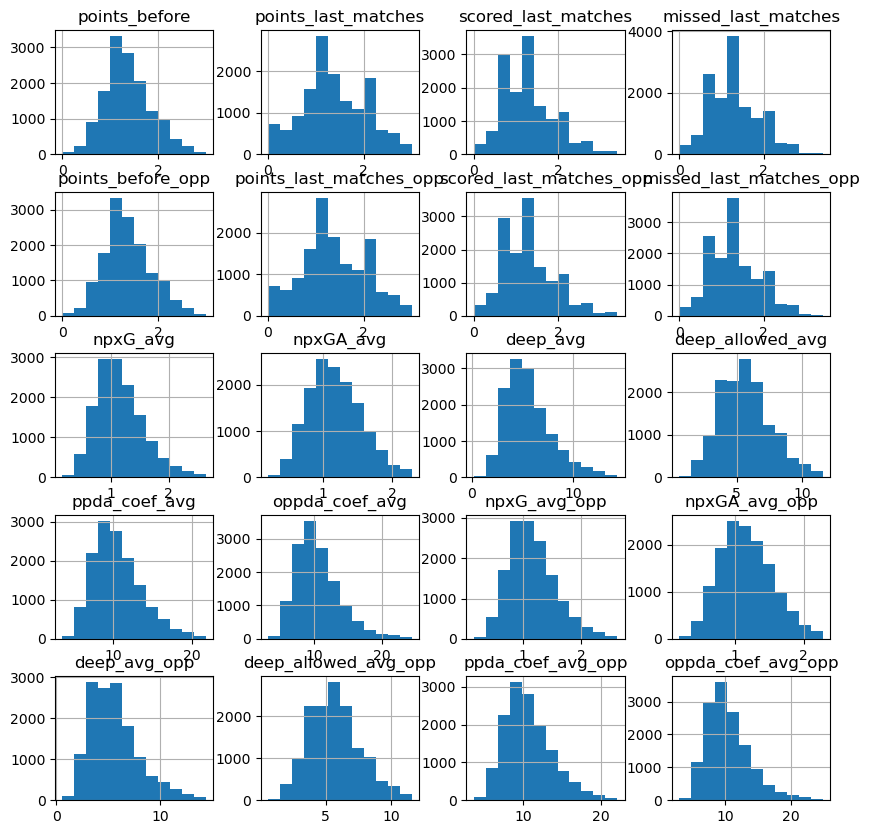

In [10]:
MAX_SCORED_LAST_MATCHES = 3.5
PRECENTILE_TO_FILTER = 0.99

quantiles = X_train[
    labels_aggregated + [label + "_opp" for label in labels_aggregated]
].quantile(PRECENTILE_TO_FILTER)

for label in [
    "scored_last_matches",
    "scored_last_matches_opp",
    "missed_last_matches",
    "missed_last_matches_opp",
]:
    quantiles[label] = MAX_SCORED_LAST_MATCHES

filtered_indexes = np.logical_and.reduce(
    [X_train[label] < quantiles[label] for label in quantiles.index]
)

X_train_filtered = X_train[filtered_indexes]
y_train_filtered = y_train[filtered_indexes]
X_train_filtered.hist(bins=12, figsize=(10, 10));

## Стандартизация признаков

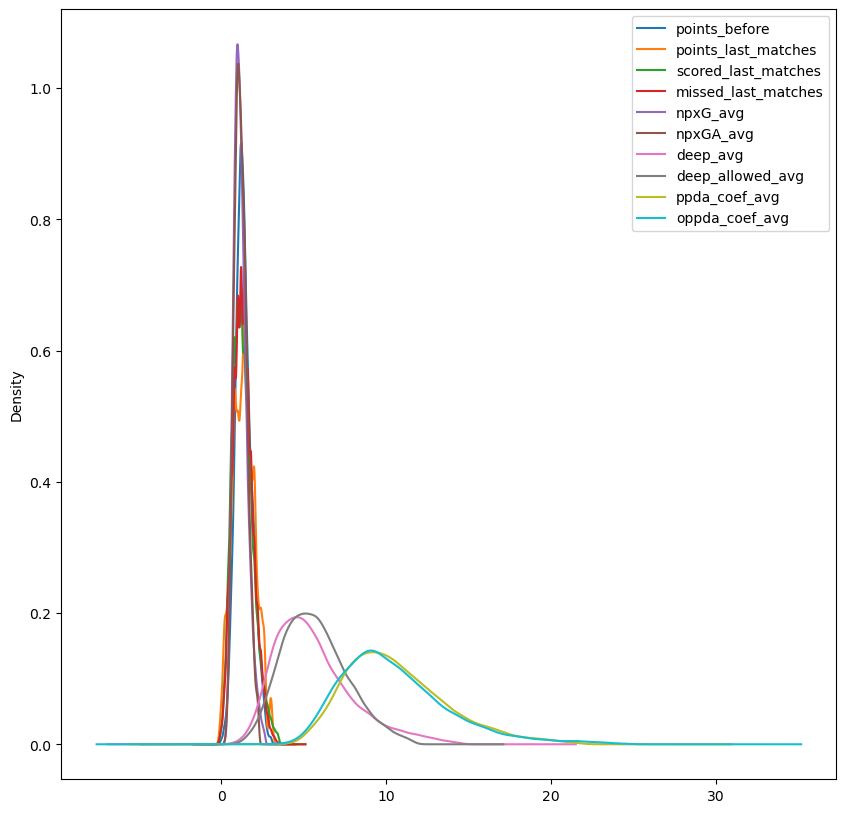

In [11]:
X_train_filtered.filter(regex="^((?!_opp).)*$", axis=1).plot.kde(figsize=(10, 10));

In [12]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_filtered), columns=X_train_filtered.columns
)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

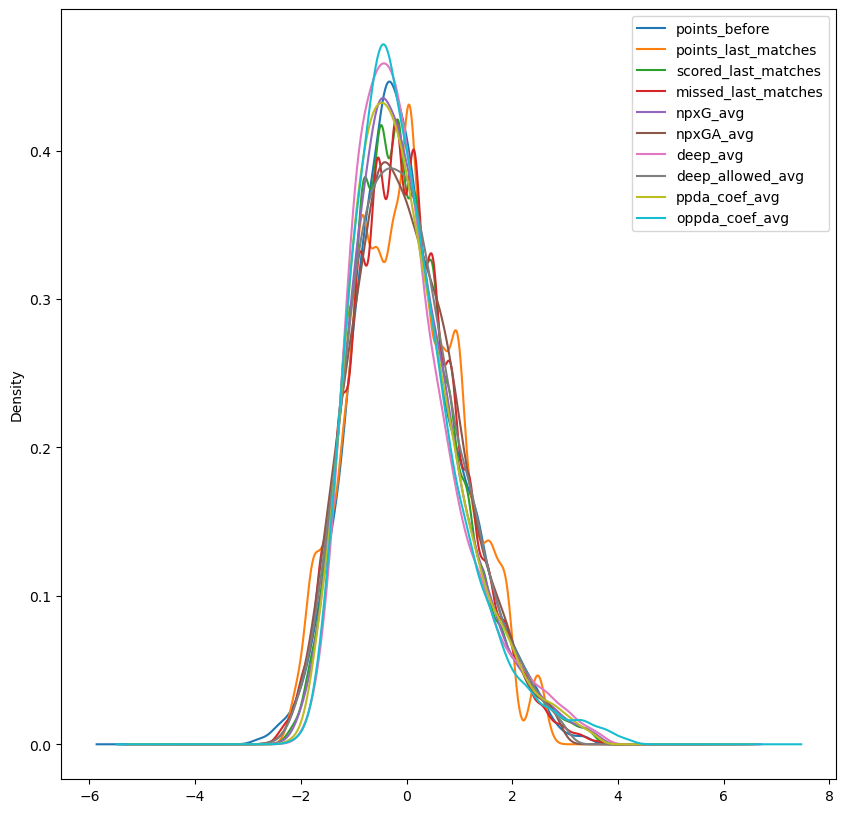

In [13]:
X_train_scaled.drop(labels="ishome", axis=1).filter(
    regex="^((?!_opp).)*$", axis=1
).plot.kde(figsize=(10, 10));

# Обучение моделей

В качестве базовых моделей возьмем следующие: 
- Dummy Classifier, 
- Logistic Regression,
- k Nearest Neighbors Classifier,
- Decision Tree.

Обучать будем на стандартизированных данных.

In [14]:
report_full = pd.DataFrame(columns=["cross_val_score", "accuracy", "f1_score"])

## Базовые модели

### Dummy Classifier

In [15]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train_filtered)

y_pred_dummy = dummy_clf.predict(X_test_scaled)

report_full.loc["DummyClassifier"] = [
    "",
    accuracy_score(y_test, y_pred_dummy),
    f1_score(y_test, y_pred_dummy, average="macro"),
]
print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1332
           l       0.00      0.00      0.00      1978
           w       0.37      1.00      0.54      1978

    accuracy                           0.37      5288
   macro avg       0.12      0.33      0.18      5288
weighted avg       0.14      0.37      0.20      5288



### Logistic Regression

In [16]:
logreg = LogisticRegression(multi_class="ovr", random_state=1111)
scores = cross_val_score(
    logreg, X_train_scaled, y_train_filtered, cv=5, scoring="f1_macro"
)

logreg.fit(X_train_scaled, y_train_filtered)
y_preds_logistic_regr = logreg.predict(X_test_scaled)

report_full.loc["LogisticRegression"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_logistic_regr),
    f1_score(y_test, y_preds_logistic_regr, average="macro"),
]
print(classification_report(y_test, y_preds_logistic_regr, zero_division=0))

              precision    recall  f1-score   support

           d       0.00      0.00      0.00      1332
           l       0.53      0.71      0.60      1978
           w       0.52      0.69      0.59      1978

    accuracy                           0.52      5288
   macro avg       0.35      0.47      0.40      5288
weighted avg       0.39      0.52      0.45      5288



### k Nearest Neighbors Classifier

In [17]:
knn = KNeighborsClassifier(n_neighbors=50, weights="uniform")
scores = cross_val_score(
    knn, X_train_scaled.values, y_train_filtered, cv=5, scoring="f1_macro"
)

knn.fit(X_train_scaled, y_train_filtered)
y_preds_knn = knn.predict(X_test_scaled.values)

report_full.loc["KNeighborsClassifier"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_knn),
    f1_score(y_test, y_preds_knn, average="macro"),
]
print(classification_report(y_test, y_preds_knn))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           d       0.26      0.07      0.11      1332
           l       0.52      0.66      0.58      1978
           w       0.52      0.64      0.57      1978

    accuracy                           0.50      5288
   macro avg       0.43      0.46      0.42      5288
weighted avg       0.45      0.50      0.46      5288



### Decision Tree

In [18]:
tree_clf = DecisionTreeClassifier()
scores = cross_val_score(
    tree_clf, X_train_scaled, y_train_filtered, cv=5, scoring="f1_macro"
)

tree_clf.fit(X_train_scaled, y_train_filtered)
y_preds_tree = tree_clf.predict(X_test_scaled)

report_full.loc["DecisionTreeClassifier"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_tree),
    f1_score(y_test, y_preds_tree, average="macro"),
]
print(classification_report(y_test, y_preds_tree))

              precision    recall  f1-score   support

           d       0.26      0.27      0.26      1332
           l       0.45      0.45      0.45      1978
           w       0.46      0.44      0.45      1978

    accuracy                           0.40      5288
   macro avg       0.39      0.39      0.39      5288
weighted avg       0.40      0.40      0.40      5288



In [19]:
# dot_data = export_graphviz(
#   tree_clf, out_file=None,
#   feature_names=X_train_scaled.columns,
#   class_names=y_test.unique(),
#   filled=True, rounded=True,
#   special_characters=True
# )

### Предварительные результаты

In [20]:
report_full

,cross_val_score,accuracy,f1_score
DummyClassifier,,0.374054,0.181485
LogisticRegression,0.3918 (0.0042),0.523449,0.399248
KNeighborsClassifier,0.4134 (0.0083),0.502458,0.419939
DecisionTreeClassifier,0.3826 (0.0041),0.401286,0.387682


## Ансамблевые модели

### Случайный лес

In [21]:
rf = RandomForestClassifier(random_state=2222)
scores = cross_val_score(rf, X_train_scaled, y_train_filtered, cv=5, scoring="f1_macro")

rf.fit(X_train_scaled, y_train_filtered)
y_preds_forrest = rf.predict(X_test_scaled)

report_full.loc["RandomForrest"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_forrest),
    f1_score(y_test, y_preds_forrest, average="macro"),
]
print(classification_report(y_test, y_preds_forrest))

              precision    recall  f1-score   support

           d       0.34      0.08      0.13      1332
           l       0.52      0.67      0.58      1978
           w       0.52      0.64      0.57      1978

    accuracy                           0.51      5288
   macro avg       0.46      0.46      0.43      5288
weighted avg       0.47      0.51      0.46      5288



### Объединение базовых моделей

Попробуем объединить несколько базовых моделей: объединим резуьтаты трех базовых моделей (Logistic Regression, k-NN Classifier, Decision Tree) так, что результат полученной комбинации равен наиболее вероятному предсказанию из трех имеющихся. 
Для случая, когда все три базовые модели имеют разные результаты (победа, ничья, поражение), будем считать суммарным результатом - ничья. Во всех же остальных случаях всегда будет наиболее вероятный вариант, встречающийся 2 или 3 раза.

In [22]:
y_pred_sum = pd.DataFrame(
    {"col1": y_preds_logistic_regr, "col2": y_preds_knn, "col3": y_preds_tree}
).mode(axis="columns")
y_pred_sum.loc[y_pred_sum.notna().all(axis=1), 0] = "d"
y_pred_sum = y_pred_sum[0]

report_full.loc["3 base models"] = [
    "",
    accuracy_score(y_test, y_pred_sum),
    f1_score(y_test, y_pred_sum, average="macro"),
]
print(classification_report(y_test, y_pred_sum))

              precision    recall  f1-score   support

           d       0.23      0.07      0.10      1332
           l       0.53      0.67      0.59      1978
           w       0.53      0.64      0.58      1978

    accuracy                           0.51      5288
   macro avg       0.43      0.46      0.42      5288
weighted avg       0.45      0.51      0.46      5288



### Предварительные результаты

In [23]:
report_full

,cross_val_score,accuracy,f1_score
DummyClassifier,,0.374054,0.181485
LogisticRegression,0.3918 (0.0042),0.523449,0.399248
KNeighborsClassifier,0.4134 (0.0083),0.502458,0.419939
DecisionTreeClassifier,0.3826 (0.0041),0.401286,0.387682
RandomForrest,0.4169 (0.0075),0.507186,0.426620
3 base models,,0.506997,0.423878


## Подбор гиперпараметров с помощью библиотеки Optuna

In [24]:
def objective_random_forest(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 500, step=10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 500, log=True)
    is_max_depth_none = trial.suggest_categorical("is_max_depth_none", [True, False])
    max_features = trial.suggest_float("max_features", 0.05, 1.0, step=0.05)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 500, log=True)

    if is_max_depth_none:
        classifier = RandomForestClassifier(
            random_state=2222,
            n_estimators=n_estimators,
            max_depth=None,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
        )
    else:
        max_depth = trial.suggest_int("max_depth", 5, 100, step=5)
        classifier = RandomForestClassifier(
            random_state=2222,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
        )

    score = cross_val_score(
        classifier, X_train_scaled, y_train_filtered, cv=5, scoring="f1_macro"
    )
    return score.mean()


def objective_knn(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 2, 130, log=False)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])

    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    score = cross_val_score(
        classifier, X_train_scaled.values, y_train_filtered, cv=5, scoring="f1_macro"
    )
    return score.mean()

### k Nearest Neighbors Classifier

In [40]:
%%time

if REEXECUTE_OPTUNA_STUDY_KNN:
    study_knn = optuna.create_study(direction="maximize")
    study_knn.optimize(objective_knn, n_trials=50)
    joblib.dump(study_knn, "study_knn.pkl")
else:
    study_knn = joblib.load("study_knn.pkl");

[I 2024-02-21 16:42:48,354] A new study created in memory with name: no-name-f9b68ecb-34f9-4328-95df-65499616e3f2
[I 2024-02-21 16:42:48,823] Trial 0 finished with value: 0.4230176008344384 and parameters: {'n_neighbors': 13, 'weights': 'distance'}. Best is trial 0 with value: 0.4230176008344384.
[I 2024-02-21 16:42:49,619] Trial 1 finished with value: 0.3981833308302364 and parameters: {'n_neighbors': 101, 'weights': 'uniform'}. Best is trial 0 with value: 0.4230176008344384.
[I 2024-02-21 16:42:50,175] Trial 2 finished with value: 0.4060098534950888 and parameters: {'n_neighbors': 69, 'weights': 'distance'}. Best is trial 0 with value: 0.4230176008344384.
[I 2024-02-21 16:42:50,919] Trial 3 finished with value: 0.3981389598550714 and parameters: {'n_neighbors': 103, 'weights': 'distance'}. Best is trial 0 with value: 0.4230176008344384.
[I 2024-02-21 16:42:51,329] Trial 4 finished with value: 0.42215069794149207 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is tria

CPU times: total: 1min 36s
Wall time: 24.2 s


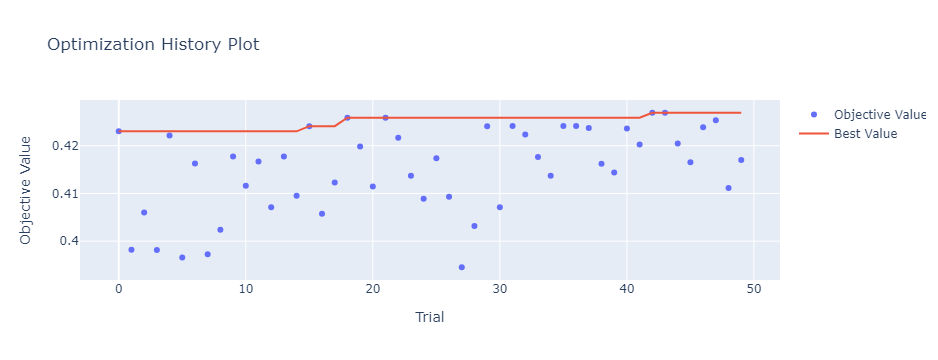

In [41]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study_knn)

In [42]:
params_knn = study_knn.best_trial.params
params_knn

{'n_neighbors': 18, 'weights': 'uniform'}

In [43]:
params_knn["n_neighbors"]

18

In [44]:
knn = KNeighborsClassifier(
    n_neighbors=params_knn["n_neighbors"], weights=params_knn["weights"]
)
scores = cross_val_score(
    knn, X_train_scaled.values, y_train_filtered, cv=5, scoring="f1_macro"
)

knn.fit(X_train_scaled.values, y_train_filtered)
y_preds_knn = knn.predict(X_test_scaled.values)

report_full.loc["KNeighborsClassifier_Optuna"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_knn),
    f1_score(y_test, y_preds_knn, average="macro"),
]
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           d       0.30      0.18      0.22      1332
           l       0.53      0.61      0.57      1978
           w       0.52      0.57      0.54      1978

    accuracy                           0.49      5288
   macro avg       0.45      0.45      0.44      5288
weighted avg       0.47      0.49      0.47      5288



### Случайный лес

In [30]:
%%time

if REEXECUTE_OPTUNA_STUDY_RANDOM_FOREST:
    study_random_forest = optuna.create_study(direction="maximize")
    study_random_forest.optimize(objective_knn, n_trials=100)
    joblib.dump(study_random_forest, "study_random_forest.pkl")
else:
    study_random_forest = joblib.load("study_random_forest.pkl");

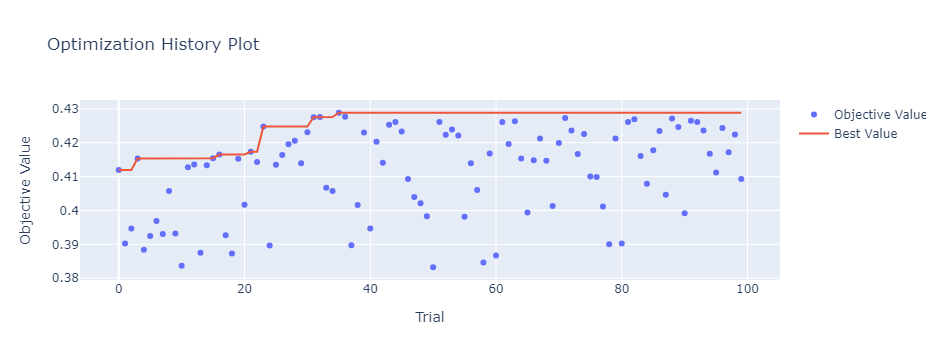

In [31]:
plot_optimization_history(study_random_forest)

In [32]:
params_rf = study_random_forest.best_trial.params
params_rf

{'n_estimators': 20,
 'min_samples_leaf': 6,
 'is_max_depth_none': True,
 'max_features': 0.9000000000000001,
 'min_samples_split': 9}

In [33]:
rf = RandomForestClassifier(
    random_state=2222,
    n_estimators=params_rf["n_estimators"],
    min_samples_leaf=params_rf["min_samples_leaf"],
    max_depth=None if params_rf["is_max_depth_none"] else params_rf["max_depth"],
    max_features=params_rf["max_features"],
    min_samples_split=params_rf["min_samples_split"],
)
scores = cross_val_score(rf, X_train_scaled, y_train_filtered, cv=5, scoring="f1_macro")

rf.fit(X_train_scaled, y_train_filtered)
y_preds_forrest = rf.predict(X_test_scaled)

report_full.loc["RandomForrest_Optuna"] = [
    "%0.4f (%0.4f)" % (scores.mean(), scores.std()),
    accuracy_score(y_test, y_preds_forrest),
    f1_score(y_test, y_preds_forrest, average="macro"),
]
print(classification_report(y_test, y_preds_forrest))

              precision    recall  f1-score   support

           d       0.29      0.12      0.17      1332
           l       0.52      0.63      0.57      1978
           w       0.52      0.62      0.56      1978

    accuracy                           0.50      5288
   macro avg       0.44      0.45      0.43      5288
weighted avg       0.46      0.50      0.47      5288



## Результаты

In [45]:
report_full

,cross_val_score,accuracy,f1_score
DummyClassifier,,0.374054,0.181485
LogisticRegression,0.3918 (0.0042),0.523449,0.399248
KNeighborsClassifier,0.4134 (0.0083),0.502458,0.419939
DecisionTreeClassifier,0.3826 (0.0041),0.401286,0.387682
RandomForrest,0.4169 (0.0075),0.507186,0.426620
3 base models,,0.506997,0.423878
KNeighborsClassifier_Optuna,0.4269 (0.0038),0.488843,0.444503
RandomForrest_Optuna,0.4289 (0.0089),0.496218,0.433017


Из представленной выше таблицы можно сделать следующие выводы:
- Наибольшего значения Accuracy удалось достичь применением логистической регрессии без какой-либо дополнительной настройки. Из classification_report видно, что полученная таким образом модель совершенно не предсказывает ничьи, поэтому низким получается значение f1-меры.
- Среди базовых моделей худший результат показало дерево решений, что говорит о необходимости настройки параметров метода.
- Объединение трех базовых моделей в одну (3 base models) улучшило значение параметра f1-меры относительно всех трех базовых моделей. В полученной ансамблевой модели полученные результаты соспоставимы с результатами работы модели случайного леса без настройки.
- С помощью настройки гиперпараметров за счет использования библиотеки Optuna удалось улучшить результаты работы моделей k-NN и случайного леса с точки зрения f1-меры, однако это привело к ухудшению значений Accuracy для обоих моделей. Можно сделать вывод о том, что не удалось достичь значительного улучшения качества предсказаний за счет настройки гиперпараметров.

## Интерпритация моделей

Оценим важность признаков для полученных моделей логистической регрессии и настроенных моделей k-NN и случайного леса с использованием параметра Permutation Importance.

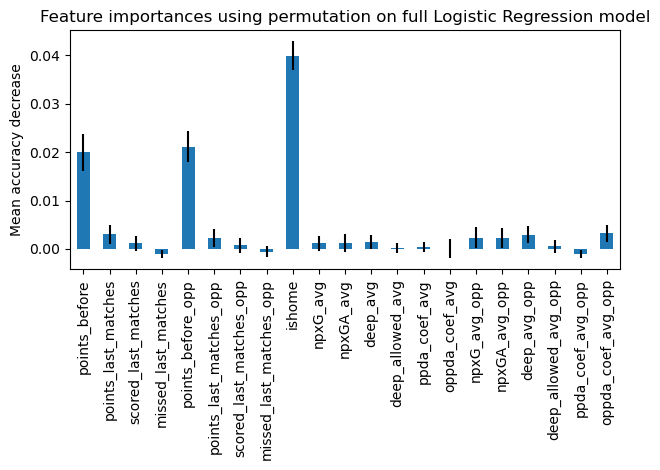

In [35]:
importances = permutation_importance(
    logreg, X_test_scaled, y_test, n_repeats=30, random_state=2222, n_jobs=2
)
logistic_regression_importances = pd.Series(
    importances.importances_mean, index=X_train.columns
)

fig, ax = plt.subplots()
logistic_regression_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full Logistic Regression model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

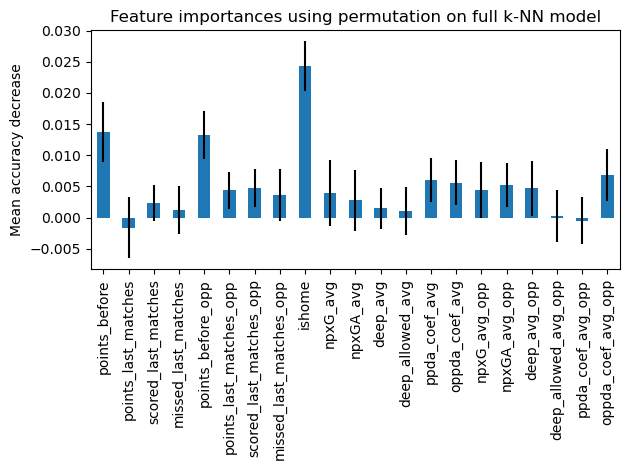

In [36]:
importances = permutation_importance(
    knn, X_test_scaled.values, y_test, n_repeats=30, random_state=2222, n_jobs=2
)
logistic_regression_importances = pd.Series(
    importances.importances_mean, index=X_train.columns
)

fig, ax = plt.subplots()
logistic_regression_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full k-NN model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

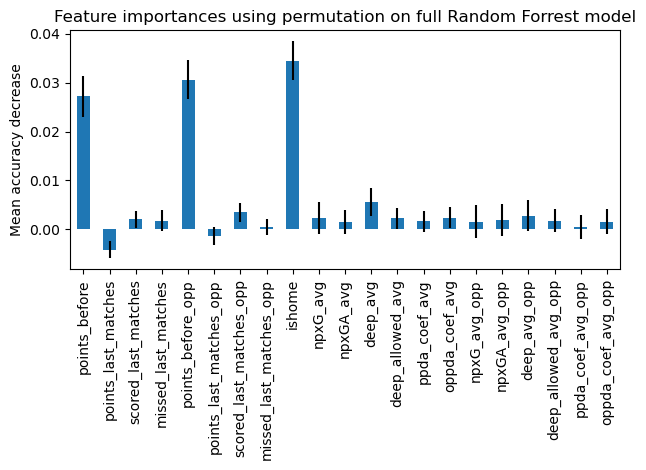

In [37]:
importances = permutation_importance(
    rf, X_test_scaled, y_test, n_repeats=30, random_state=2222, n_jobs=2
)
logistic_regression_importances = pd.Series(
    importances.importances_mean, index=X_train.columns
)

fig, ax = plt.subplots()
logistic_regression_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full Random Forrest model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

На основании представленных графиков можно заметить, что для всех трех проанализированных моделей наиболее важными являются следующие параметры:
- Количество очков, набранных в сезоне к моменту начала. points_before и points_before_opp для первой и второй команды в записи соответственно.
- Игра дома или в гостях.

Важность всех оставльных признаков варьируется в зависимости от модели, однако почти всегда вклад этих признаков очень мал. Это говорит о том, что либо эти признаки не влияют на результат, либо их влияние описывается более сложными зависимостями, выявить которые не удалось.